In [3]:
from utils import *
import fastbook
fastbook.setup_book()
#hide
from fastbook import *


In [4]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [5]:
import pandas as pd
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [6]:
df.iloc[:,0]

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [7]:
df.iloc[0,:]
# or
# df[0] 

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

In [8]:
df['fname']

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [9]:
## Making a datablock
a = list(enumerate(string.ascii_lowercase))
dl_a = DataLoader(a, batch_size=8, shuffle=True)
b = first(dl_a)
b

(tensor([ 7, 24, 17, 21,  5, 19,  9, 15]),
 ('h', 'y', 'r', 'v', 'f', 't', 'j', 'p'))

In [11]:
list(zip(*b))

[(tensor(7), 'h'),
 (tensor(24), 'y'),
 (tensor(17), 'r'),
 (tensor(21), 'v'),
 (tensor(5), 'f'),
 (tensor(19), 't'),
 (tensor(9), 'j'),
 (tensor(15), 'p')]

In [12]:
# Dataset
a = list(string.ascii_lowercase)
a[0]

'a'

In [13]:
dss = Datasets(a)
dss[1]

('b',)

In [14]:
def f1(o): return o+'a'
def f2(o): return o+'b'

In [16]:
# Transformations for dataset
dss = Datasets(a, [[f1]])
dss[0]

('aa',)

In [17]:
dss = Datasets(a, [[f1, f1]])
dss[0]

('aaa',)

In [18]:
# Passes the value first to F1, and then passes the value again to F2 and generates 2 values (independent var, dependent var).
dss = Datasets(a, [[f1], [f2]])
dss[0]

('aa', 'ab')

In [22]:
dls = DataLoaders.from_dsets(dss, batch_size=4)
first(dls.train)

(('ha', 'ea', 'ua', 'ta'), ('hb', 'eb', 'ub', 'tb'))

In [23]:
# Datablock
dblock = DataBlock()
dsets = dblock.datasets(df)

In [24]:
len(dsets.train), len(dsets.valid)

(4009, 1002)

In [25]:
x,y = dsets.train[0]

In [26]:
x,y

(fname         009659.jpg
 labels      chair person
 is_valid           False
 Name: 4856, dtype: object,
 fname         009659.jpg
 labels      chair person
 is_valid           False
 Name: 4856, dtype: object)

In [27]:
# They are the same, (ind. and dep. variable) by defautl dblock assumes we have 2 things, input -> target, and just copies it on both sides
# and by default splits 80:20 to train:valid 

In [29]:
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[1]

('007416.jpg', 'cat chair')

In [30]:
# If we want to save datablock for later use, do not use lambda just use a declared function so python can serialize it automatically.

In [31]:
Path.BASE_PATH = path

In [36]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dset = dblock.datasets(df)
dset.train[4]

(Path('train/005478.jpg'), ['sofa', 'person'])

In [37]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x,
                   get_y = get_y,)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=333x500,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [38]:
# One Hot Encoding, where there is 1 in the place for the corresponding to the label(s) of the object in the image

In [40]:
# This will tell you all the indices where there is 1 in the 1 hot encoded tensor.
# These indices correspond to the train vocab, this we can get the name of the category as follows:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#1) ['dog']

In [42]:
#Customized splitter if the dataset has it's own valid/train split
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=get_x,
                   get_y=get_y,
                   splitter=splitter)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

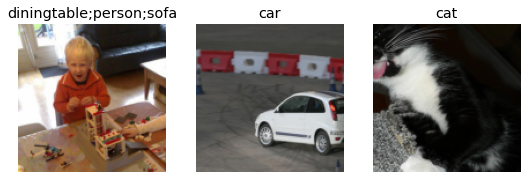

In [46]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=get_x,
                   get_y=get_y,
                   splitter=splitter,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)
dls.show_batch(nrows=1, ncols=3)

In [52]:
learn = cnn_learner(dls, resnet18)
x,y = dls.train.one_batch()
activs = learn.model(x)
activs.shape

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [48]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return torch.where(targets==1, 1-inputs, inputs).log().mean()

In [50]:
# F.binary_cross_entropy_with_logits (to include the sigmooid) normally it does not include sigmoid

In [51]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)

NameError: name 'activs' is not defined

In [53]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    if sigmoid: inp = inp.sigmoid()
    return ((inp >thresh) == targ.bool()).float().mean()

In [78]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi,thresh=0.5))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.950728,0.694662,0.631155,00:14
1,0.827587,0.555684,0.742769,00:14
2,0.606434,0.199305,0.949602,00:14
3,0.363891,0.125173,0.955598,00:14


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.136837,0.117532,0.959482,00:18
1,0.117516,0.109626,0.960856,00:18
2,0.097673,0.102534,0.962988,00:18


In [70]:
learn.metrics = partial(accuracy_multi, thresh=0.9)
learn.validate()

(#2) [0.10422170907258987,0.9568924307823181]

In [71]:
learn.metrics = partial(accuracy_multi, thresh=0.2)
learn.validate()

(#2) [0.10422170907258987,0.9513944983482361]

In [72]:
## How to get the best accuracy threshold
preds, targets = learn.get_preds()

In [77]:
doc(learn.get_preds)

Learner.get_preds [source] Learner.get_preds ( ds_idx = 1 , dl = None , with_input = False , with_decoded = False , with_loss = False , act = None , inner = False , reorder = True , cbs = None , save_preds = None , save_targs = None , with_preds = True , with_targs = True , concat_dim = 0 , pickle_protocol = 2 ) 
 
 Get the predictions and targets on the ds_idx -th dbunchset or dl , optionally with_input and with_loss 
 
 
 
 Type 
 Default 
 
 
 
 
 ds_idx 
 int 
 1 
 
 
 dl 
 
 None 
 
 
 with_decoded 
 bool 
 False 
 
 
 act 
 
 None 
 
 
 inner 
 bool 
 False 
 
 
 reorder 
 bool 
 True 
 
 
 cbs 
 
 None 
 
 
 
 
 Valid Keyword Arguments 
 
 
 
 
 Type 
 Default 
 
 
 --- 
 --- 
 --- 
 
 
 with_input 
 bool 
 False 
 
 
 with_loss 
 bool 
 False 
 
 
 save_preds 
 
 None 
 
 
 save_targs 
 
 None 
 
 
 with_preds 
 bool 
 True 
 
 
 with_targs 
 bool 
 True 
 
 
 concat_dim 
 int 
 0 
 
 
 pickle_protocol 
 int 
 2 
 
 
 
 Show in docs

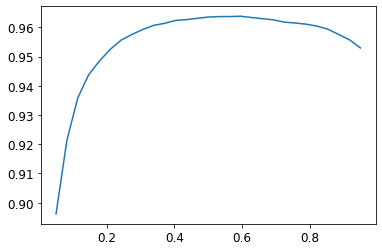

In [74]:
xs = torch.linspace(0.05, 0.95, 29)
accs = [accuracy_multi(preds, targets, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

In [79]:
# Image regression

In [123]:
path = untar_data(URLs.BIWI_HEAD_POSE)
Path.BASE_PATH = path

In [125]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('09/frame_00635_pose.txt')

In [134]:
str(img_files[0])

'/home/jupyter/.fastai/data/biwi_head_pose/09/frame_00635_rgb.jpg'

In [135]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

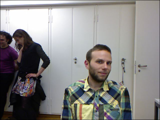

In [136]:
im.to_thumb(160)

In [137]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [138]:
get_ctr(img_files[0])

tensor([414.3000, 259.8248])

In [141]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=aug_transforms(size=(240,320)), 
)

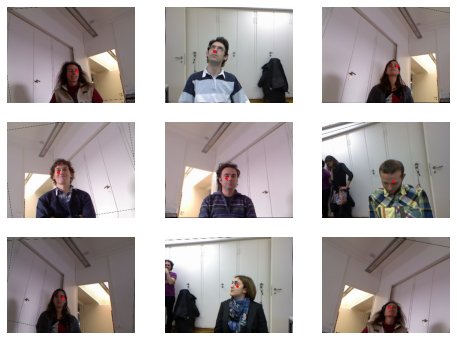

In [142]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [143]:
xb,yb = dls.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [144]:
# 64 - batch size
# 3 number of channels, colors, one representation of each color
# 240,320 image size (rows cols)
# 1,2 is 1 point with 2 values (in yb)

In [145]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))
# Y range , what range of data we expect to see in dependent variable.
# Range of coordinate is -1,1 


In [146]:
dls.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(valley=0.001737800776027143)

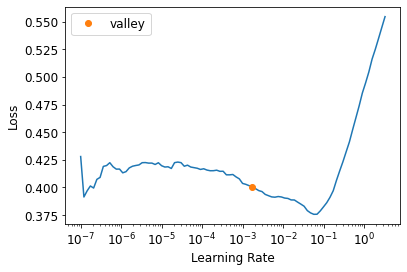

In [147]:
learn.lr_find()

In [148]:
lr = 0.001
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.227608,0.017751,01:36


epoch,train_loss,valid_loss,time
0,0.081468,0.003811,02:09
1,0.018733,0.002321,02:09
2,0.010380,0.002259,02:09


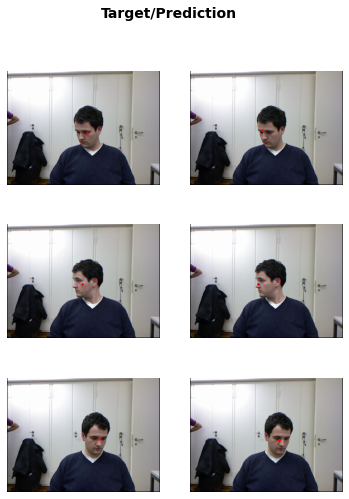

In [154]:
learn.show_results(ds_idx=1, max_n=3, figsize=(6,8))